# MSc in AI - CE6002


# E-tivity 3: Basic Techniques for Learning
# Task 3 - Linear Classification
-----

## Student Name: Mark Murnane
## Student ID: 18195326

-----

### Existing Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [2]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(n_samples=1000, noise = 0.05)
y = [yy if yy == 1 else -1 for yy in y] 

### Visualise the Data Set

By visualising the data set there is a danger of engaging in _Data Snooping_ that would "contaminate" the final hypothesis (or weights) that will be calculated by the Linear Classification algorithm shown later. It is useful for this learning exercise, however, to have an idea of how the data looks in order to properly understand the choices made later on.

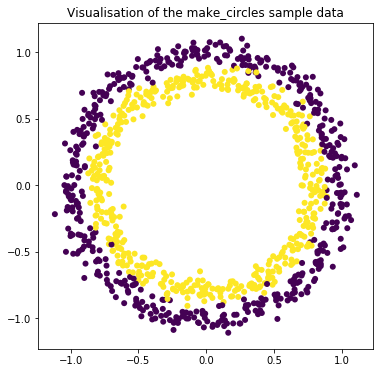

In [3]:
# Set general figure size to be square
plt.rcParams["figure.figsize"] = (6,6)

# Generate a Scatter plot of the data set
plt.scatter(X[:,0], X[:,1], c=y, linewidths=0)
plt.title("Visualisation of the make_circles sample data")
plt.show()

The visualisation clearly shows that the data cannot be linearly separated.

## Task 3

### Linear Classification Implementation

The first set of functions are taken from earlier Etivity code (specifically from Pep's example visualisations in Etivity 1).

In [4]:
def calc_error(y_predict, y_actual):
    errors=0
    for x,y in zip(y_predict, y_actual):
        if (x!=y):
            errors+=1;
    return errors/len(y_actual)

# Borrowed/modified from Etivity 1 code
def point_on_boundary(bias, weight_1, weight_2, x):
    # Return the y-position on the boundary based on given x-position
    return -(bias+weight_1*x)/weight_2

def decision_boundary(bias, weight_1, weight_2, x_min, x_max):
    # Return two points on the decision boundary
    return [point_on_boundary(bias, weight_1, weight_2, x_min), point_on_boundary(bias, weight_1, weight_2, x_max)]

#### Algorithm

The following class implements the Linear Classification algorithm. The initial motivation was to make it easy to use manage the weights and to follow the Scikit-Learn pattern of having a `fit()` method the initialises the algorithm, with another method that actually applies the calculations to a data set.

For now the the `predict()` method performs all of the calculation.  The variant in Task 4 will have `predict()` apply the sign function to the output of a `score()` method that applies the _Linear Regression_ operation to the input.

In [5]:
class MyLinearClassifier(object):
    
    """Implementation of simple Linear Classification algorithm based on the algorithm outlined
       in Learning from Data, Chapter 3"""
    
    # Simple initialiser to make sure we have a instance variable for weights
    def __init__(self):
        self.weights_ = np.array([])

    # Fit function to determine the weights to be used by the classifer
    # This algorithm is based on Learning from Data, p.86 
    def fit(self, X_in, y_in):        
        # Add the bias coordinate to the input array
        X = np.hstack((np.ones((X_in.shape[0],1)), X_in))              
        
        # Pseudo-code
        #w = (((X^transpose@X)^-1)X^transpose)@y       

        # Shorthand Xd = np.linalg.pinv(X)
        # Do this the long way for understanding for now
        Xt = np.transpose(X)
        Xd = np.matmul(np.linalg.inv(np.matmul(Xt, X)), Xt)

        self.weights_ = np.matmul(Xd, y_in)


    # Predicts a set of output classes (y^) based in the input attributes and this model's weights
    def predict(self, X_in):
        X = np.hstack((np.ones((X_in.shape[0],1)), X_in))
        y_hat = np.matmul(X, self.weights_)

        return np.sign(y_hat)            

Before proceeding with any classification on data set we'll split the data in a Train/Test set using the `train_test_split` functionality of Scikit-learn.

Initially I did not do this as I felt that in previous exercises the main motivation for doing this was linked to the iterative nature of the algorithms.  As Linear Regression/Classification is "one step" it felt unnecessary.  On reflection, however, it's clear that every algorithm needs to generalise well (have a good $E_{out}$), and as Pep neatly summarised i the Forums, there can still be noise and spurious trends in data.

In reality, on my first pass I was guilty of snooping!

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

Now that data is split, apply the Linear Classifier to it.  Before calculating $E_{in}$ we'll use counts of unique values to get a sense of how close $\hat{y}$ is to the training sample.

In [7]:
mlc = MyLinearClassifier()
mlc.fit(X_train, y_train)

y_hat = mlc.predict(X_train)

print("The unique values and their respective counts for the training set and the prediction based on the training set are:\n")
print(f"Training Set:\t{np.unique(y_train, return_counts=True)}")
print(f"Predicted Set:\t{np.unique(y_hat, return_counts=True)}")

The unique values and their respective counts for the training set and the prediction based on the training set are:

Training Set:	(array([-1,  1], dtype=int64), array([401, 399], dtype=int64))
Predicted Set:	(array([-1.,  1.]), array([418, 382], dtype=int64))


The above value just tells us a distribution of values.  It does not tell us how accurate we are.  For that we need to calculate the in-sample error $E_{in}$

In [8]:
print(f"In sample error is:\t{calc_error(y_hat, y_train)}")

In sample error is:	0.48625


In [9]:
# Evaluate the Test set to estimate Eout
y_hat = mlc.predict(X_test)
print(f"The out of sample error is:\t{calc_error(y_hat, y_test)}")

The out of sample error is:	0.56


The Out-of-Sample error $E_{out}$ is worse than our In-Sample error $E_{in}$.

-----

Using the whole data set, we can visualise the prediction as follows:

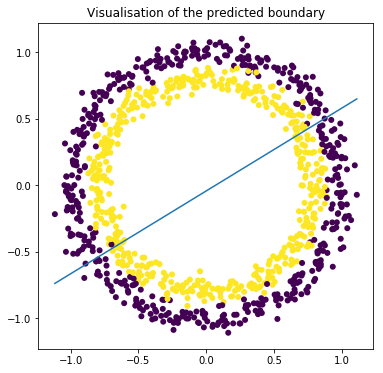

In [10]:
# Get the min and max of the 'X-axis' values
x_min = np.min(X[:,0])
x_max = np.max(X[:,0])

# Calculate the decision boundary
y_min, y_max = decision_boundary(*mlc.weights_.T, x_min, x_max)

# Plot the transformed data and the decision boundry in the Z space
plt.scatter(X[:,0], X[:,1], c=y, linewidths=0)
plt.title("Visualisation of the predicted boundary")
plt.plot([x_min, x_max], [y_min, y_max])

plt.show()

## Initial Classification Observations

The value of $E_{in}$ demonstrates that simple Linear Classification of the sample cannot be achieved.  The error rate is approaching 50%.  This stands to reason, however, as the plot shows that there is no straight line that could be drawn through the sample space that would not results in 50% of the samples being incorreclty classified. 

-----

## New Feature Creation

The plot shows that the data creates a circular plot which clearly can't be linearly separated.  To separate the two classes we'll need to use a non-linear transformation. 

It is logical to move the next higher order polynomial (in this case a 2nd order polynomial, or _quadratic_ function) and test it against the data set.  To do this I'll utilise Scikit-Learn's `PolynomialFeatures` class.  This will generate new features as well as keeping the existing features.  

While the visualisation (as well as the lectures and examples) clearly show a feature set that could separate the data, by keeping the original features and using a **_pre-defined_** algorithm for generating new features then we are properly accounting for the complexity and not (blatantly) data snooping.

In [11]:
# Generate new features, but exclude the bias as my Classifier Implmentation does this already
polygen = PolynomialFeatures(degree=2, include_bias = False)

poly_X_train = polygen.fit_transform(X_train)
poly_X_test = polygen.fit_transform(X_test)
print(poly_X_train)

[[ 0.76986074  0.65262208  0.59268555  0.50242812  0.42591558]
 [-0.397852   -0.68442653  0.15828621  0.27230047  0.46843968]
 [ 0.86802192 -0.32007462  0.75346205 -0.27783179  0.10244776]
 ...
 [ 0.15451529  0.97631832  0.02387497  0.1508561   0.95319746]
 [ 0.91117728  0.30231734  0.83024404  0.27546469  0.09139578]
 [ 0.84910726  0.19900225  0.72098314  0.16897426  0.0396019 ]]


The new data set consists of all of the polynomial combinations of the original set.  This should allow us to find a hypothesis that matches the data while maintaining the ability to generalise, as we haven't predetermined which of these new features will be most important.

We can repeat the experiment from above.

In [12]:
poly_mlc = MyLinearClassifier()
poly_mlc.fit(poly_X_train, y_train)

y_hat = poly_mlc.predict(poly_X_train)

print(f"In sample error is:\t\t{calc_error(y_hat, y_train)}")

y_hat = poly_mlc.predict(poly_X_test)
print(f"The out of sample error is:\t{calc_error(y_hat, y_test)}")

In sample error is:		0.03
The out of sample error is:	0.02


The value of $E_{in}$ has decreased significantly and now indicates that we have a good classification of the data.  We can also see that $E_{out}$ has tracked $E_{in}$.

Without having specifically chosen which of the new features are most important, we can examine the weights to determine which features have been determined to be most important.

In [13]:
print(poly_mlc.weights_)

[ 3.55403234  0.04663858 -0.01621908 -4.35496076 -0.04436243 -4.28613744]


This indicates that the 3rd and 5th features (index 0 = bias) have the highest weights, corresponding to the square of our original inputs.

In [14]:
print(poly_X_train)

[[ 0.76986074  0.65262208  0.59268555  0.50242812  0.42591558]
 [-0.397852   -0.68442653  0.15828621  0.27230047  0.46843968]
 [ 0.86802192 -0.32007462  0.75346205 -0.27783179  0.10244776]
 ...
 [ 0.15451529  0.97631832  0.02387497  0.1508561   0.95319746]
 [ 0.91117728  0.30231734  0.83024404  0.27546469  0.09139578]
 [ 0.84910726  0.19900225  0.72098314  0.16897426  0.0396019 ]]


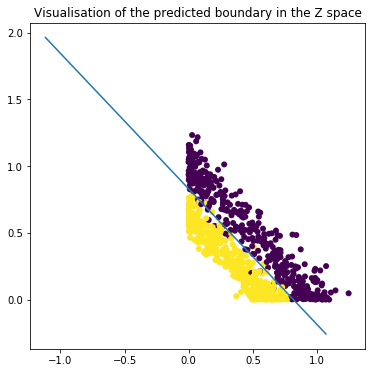

In [15]:
# Get the min and max of the 'X-axis' values
x_min = np.min(poly_X_train[:,0])
x_max = np.max(poly_X_train[:,0])

# Calculate the decision boundary
y_min, y_max = decision_boundary(poly_mlc.weights_[0], poly_mlc.weights_[3], poly_mlc.weights_[5], x_min, x_max)

# Plot the transformed data and the decision boundry in the Z space
plt.scatter(poly_X_train[:,2], poly_X_train[:,4], c=y_train, linewidths=0)
plt.title("Visualisation of the predicted boundary in the Z space")
plt.plot([x_min, x_max], [y_min, y_max])

plt.show()

By creating new features that represented the transformed the data non-linearly, a new representation of the data was created in the $Z$ space.  As the plot above shows, in this space the data is linearly separable and the implementation of Linear Classification can be used to classify the data.

As we can see from the figures above, the values of $E_{in}$ and $E_{out}$ are low and track together, so we have good generalisation and **_learning_** can be said to have taken place.



### Logistic Regression



In [16]:
# Create Logistic Regression solver instance.  Used lbfgs due to small data set size
logit = LogisticRegression(solver='lbfgs', max_iter=1000)

# Try logistic regression on the original data set
logit.fit(X_train, y_train)

y_hat = logit.predict(X_train)
logit_e_in = calc_error(y_hat, y_train)

print(f"The In-Sample error E_in for Logistic Regression with original data is: {logit_e_in} ({logit.n_iter_} iterations)")

logit.fit(poly_X_train, y_train)
y_hat = logit.predict(poly_X_train)
logit_e_in = calc_error(y_hat, y_train)

print(f"The In-Sample error E_in for Logistic Regression with new features is: {logit_e_in} {logit.n_iter_} iterations")


The In-Sample error E_in for Logistic Regression with original data is: 0.4875 ([5] iterations)
The In-Sample error E_in for Logistic Regression with new features is: 0.02625 [16] iterations


The Logistic Regression function uses a different approach.  Rather than solving directly as the Linear Classification implementation does, it minimises a cost function, in this case the **_cross-entropy error_**. 

While the Logistic Regression implementation in Scikit-Learn has more parameters and is  more flexible than the simple classifier above, for a simple scenario it required multiple iterations vs. single iteration.

Importantly, the results generated by the two models for both the initial and new features are very similar.  This similarity shows that for an appropriate data set, Linear Regression/Classification can be a computationally efficient way to solve/take a good first pass at identifying $h(x)$